In [1]:
from importlib import reload
import os
from time import time
import copy

import sys
sys.path.append('/homefs/home/wongfanc/density-ratio-estimation/')

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.weightstats import _zstat_generic

import random

import torch
print(torch.cuda.is_available())
from keras import backend as K

import pprint
import editdistance

import utils
import tdre
import shifts
import designdata as dd
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

True


2024-01-31 20:58:10.399675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 20:58:10.399717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 20:58:10.400884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 20:58:10.407629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 20:58:12.183678: W tensorflow/comp

<IPython.core.display.Javascript object>

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], True
)

In [49]:
# load data generated by gfp-pex-011123.ipynb
hp_name = 'threshold'
hp_vals = [0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.01]
avg_n_mut = 10
m = len(hp_vals)
n = 500
N = 500
model_name = 'cnn'
noise_sd = 0
path = '/data/wongfanc/dre-data/data/013023/trial0/'
contains_embeddings = False

seq_len = 238
alphabet = s_utils.AAS
d = seq_len * len(alphabet)

X_mxnxd = np.zeros([m, N, d])
y_mxn = np.zeros([m, N])
pred_mxn = np.zeros([m, N])
testseqs_list = []
testembs_list = []

for k, val in enumerate(hp_vals):
    fname = '{}-n{}-nmut{}-nsd{}-{}{}.npz'.format(model_name, n, avg_n_mut, noise_sd, hp_name, val)
    save_fname = os.path.join(
        path, fname
    )
    print('Loading from {}'.format(save_fname))
    loaded_dict = np.load(save_fname)

    # design data
    testseqs_n = loaded_dict['testseqs_n']
    testseqs_list.append(testseqs_n)
    Xk_nxd = np.array([s_utils.string_to_one_hot(seq, alphabet).flatten() for seq in testseqs_n])
    X_mxnxd[k] = Xk_nxd
    y_mxn[k] = loaded_dict['ytest_n']
    pred_mxn[k] = loaded_dict['predtest_n']
    if contains_embeddings:
        embtest_nxd = loaded_dict['embtest_nxd']
        testembs_list.append(embtest_nxd)

# training and calibration sequences. could load from any hp_val, all the same training sequences
loaded_dict = np.load(save_fname)
trainseqs_n = loaded_dict['trainseqs_n'] 
Xtr_nxd = np.array([s_utils.string_to_one_hot(seq, alphabet).flatten() for seq in trainseqs_n])
if contains_embeddings:
    embtr_nxd = loaded_dict['embtr_nxd']
calseqs_n = loaded_dict['calseqs_n']
assert(len(trainseqs_n) == n)
assert(len(calseqs_n) == n)
Xcal_nxd = np.array([s_utils.string_to_one_hot(seq, alphabet).flatten() for seq in calseqs_n])
if contains_embeddings:
    embcal_nxd = loaded_dict['embcal_nxd']
Xtrcal_nxd = np.concatenate([Xtr_nxd, Xcal_nxd], axis=0)

ytrain_n = loaded_dict['ytrain_n']
ycal_n = loaded_dict['ycal_n']
predcal_n = loaded_dict['predcal_n']
# return X_mxnxd, y_mxn, pred_mxn, Xtrcal_nxd, Xcal_nxd, ycal_n, predcal_n

Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.9.npz
Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.7.npz
Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.5.npz
Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.3.npz
Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/013023/trial0/cnn-n500-nmut10-nsd0-threshold0.01.npz


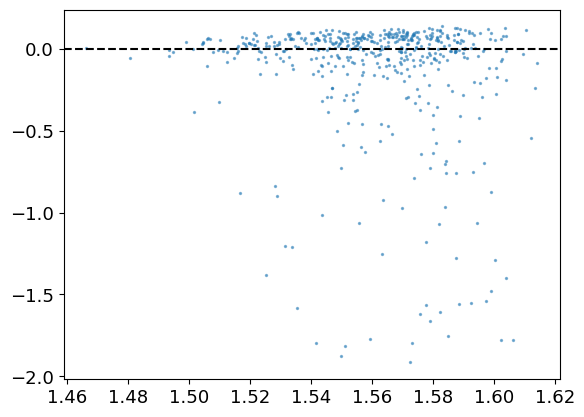

In [50]:
plt.scatter(predcal_n, predcal_n - ycal_n, alpha=0.5, s=2, label='validation');
plt.axhline(0, linestyle='--', color='k');

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Using seed ed_18_wt.


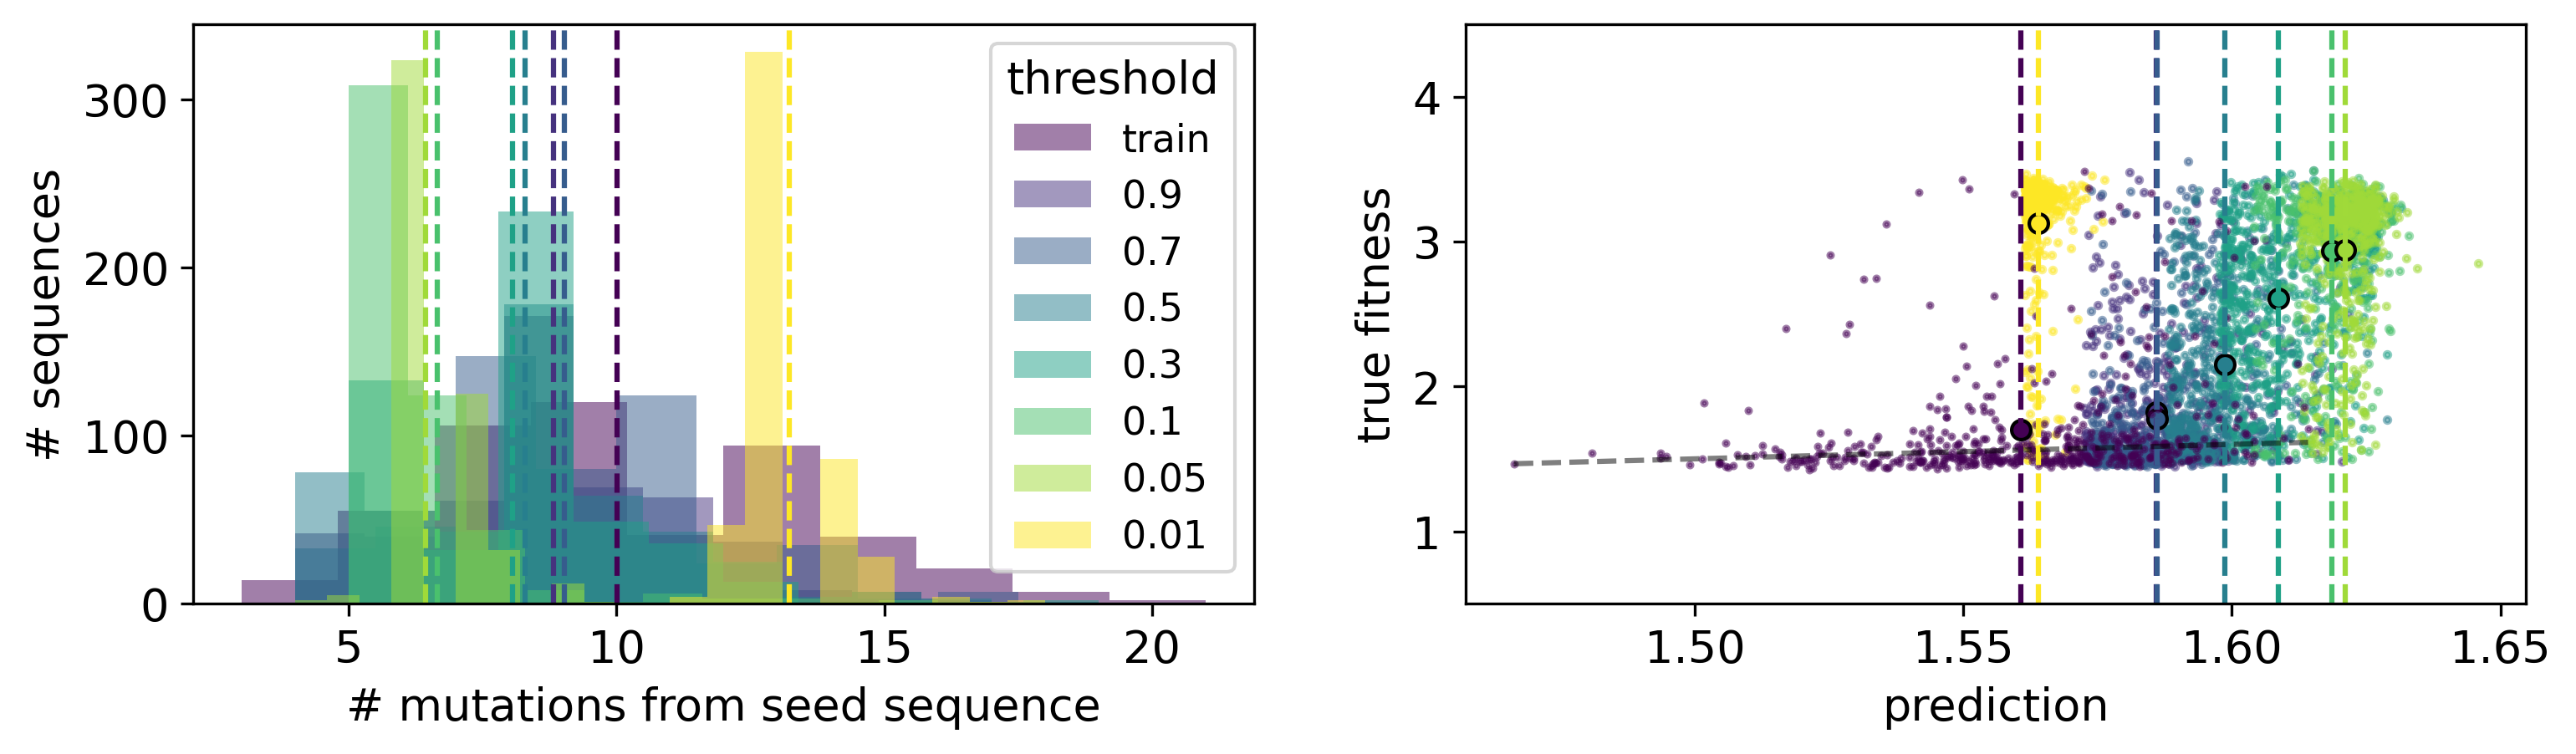

In [51]:
factory = dd.DesignDataFactory('gfp', noise_sd=noise_sd)

scatter_y_lim = [0.5, 4.5]
diag_line_lim = [np.min(predcal_n), np.max(predcal_n)]
font = {'size' : 13}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.colormaps['viridis']
disttrain_n = np.array([editdistance.eval(factory.seed, s) for s in trainseqs_n])

plt.figure(figsize=(12, 3), dpi=300)

plt.subplot(121)
plt.hist(disttrain_n, alpha=0.5, label='train', color=cmap(0));
plt.axvline(np.mean(disttrain_n), alpha=1, linestyle='--', color=cmap(0))
plt.xlabel('# mutations from seed sequence');
plt.ylabel('# sequences');


for i, (testseqs_n, ytest_n, predtest_n) in enumerate(zip(testseqs_list, y_mxn, pred_mxn)):
    color = cmap((i + 1) / len(hp_vals))
    plt.subplot(121)
    disttest_n = np.array([editdistance.eval(factory.seed, s) for s in testseqs_n])
    plt.hist(disttest_n, alpha=0.5, label=hp_vals[i], color=color);
    plt.axvline(np.mean(disttest_n), linestyle='--', color=color)

    plt.subplot(122)
    plt.scatter(predtest_n, ytest_n, alpha=0.5, s=scatter_s, color=color);
    plt.axvline(np.mean(predtest_n), alpha=1, linestyle='--', color=color);

for i, (_, ytest_n, predtest_n) in enumerate(zip(testseqs_list, y_mxn, pred_mxn)):
    plt.subplot(122)
    color = cmap((i + 1) / len(hp_vals))
    plt.scatter(np.mean(predtest_n), np.mean(ytest_n), color=color, alpha=1, s=30, edgecolor='k');

plt.subplot(121)
plt.legend(title=hp_name, fontsize=11);

plt.subplot(122)
plt.scatter(predcal_n, ycal_n, alpha=0.5, s=2, label='validation', color=cmap(0));
plt.scatter(np.mean(predcal_n), np.mean(ycal_n), color=cmap(0), alpha=1, s=30, edgecolor='k');
plt.plot(diag_line_lim, diag_line_lim, '--k', alpha=0.5);
plt.axvline(np.mean(predcal_n), alpha=1, linestyle='--', color=cmap(0))

# plt.xlim(scatter_lim);
plt.ylim(scatter_y_lim);
plt.ylabel('true fitness');
plt.xlabel('prediction');



(45000, 4760)
Done fitting in 32 s


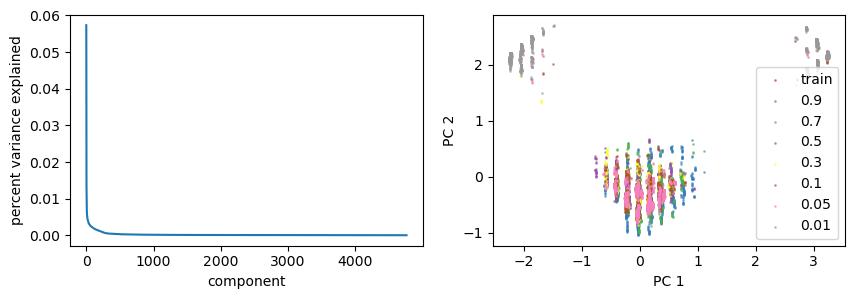

In [8]:
# PCA of OHE
cmap = matplotlib.colormaps['Set1']

Xall_nxp = np.vstack([Xtrcal_nxd] + [x for x in X_mxnxd])
print(Xall_nxp.shape)
pca = PCA()
t0 = time()
pca.fit(Xall_nxp)
print('Done fitting in {} s'.format(int(time() - t0)))

plt.figure(figsize=(10, 3))
plt.subplot(121)

plt.plot(pca.explained_variance_ratio_);
plt.ylabel('percent variance explained');
plt.xlabel('component')

# train
pc_nxp = pca.transform(Xtrcal_nxd)

plt.subplot(122)
plt.scatter(pc_nxp[:, 0], pc_nxp[:, 1], color=cmap(0), s=1, alpha=0.5, label='train')

for i, X_nxd in enumerate(X_mxnxd):
    color = cmap((i + 1) / len(hp_vals))
    pc_nxp = pca.transform(X_nxd)
    plt.scatter(pc_nxp[:, 0], pc_nxp[:, 1], color=color, s=1, alpha=0.5, label=hp_vals[i])

plt.legend()
plt.xlabel('PC 1');
plt.ylabel('PC 2');

# ESM embeddings

In [61]:
esm_model, esm_alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t30_150M_UR50D")

Using cache found in /homefs/home/wongfanc/.cache/torch/hub/facebookresearch_esm_main
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /homefs/home/wongfanc/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /homefs/home/wongfanc/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


In [62]:
def get_esm_representations(seq_n, esm_model, esm_alphabet, batch_size: int = 200, layer: int = 33):
    batch_converter = esm_alphabet.get_batch_converter()
    esm_model.eval()

    data = [('seq{}'.format(i), seq) for i, seq in enumerate(seq_n)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != esm_alphabet.padding_idx).sum(1)
    
    x_nxp = []
    n_batch = int(np.ceil(len(seq_n) / batch_size))
    for b in range(n_batch):

        # Extract per-residue representations (on CPU)
        with torch.no_grad():
            results = esm_model(
                batch_tokens[b * batch_size : (b + 1) * batch_size],
                repr_layers=[layer],
                return_contacts=True
            )
        token_representations = results["representations"][layer]

        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        sequence_representations = []
        for i, tokens_len in enumerate(batch_lens[b * batch_size : (b + 1) * batch_size]):
            sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
        x_nxp = x_nxp + [x.numpy()[None, :] for x in sequence_representations]
    x_nxp = np.vstack(x_nxp)
        
    return x_nxp

In [63]:
batch_size = 100
layer = 30

thresh2rep = {}
t0 = time()
for i, testseqs_n in enumerate(testseqs_list):
    rep_nxp = get_esm_representations(
        testseqs_n, esm_model, esm_alphabet, batch_size=batch_size, layer=layer
    )
    thresh2rep[hp_vals[i]] = rep_nxp
    print('done with {} / {} ({} s)'.format(i, len(testseqs_list), int(time() - t0)))

# training sequences
trainrep_nxp = get_esm_representations(
    trainseqs_n, esm_model, esm_alphabet, batch_size=batch_size, layer=layer
)

calrep_nxp = get_esm_representations(
    calseqs_n, esm_model, esm_alphabet, batch_size=batch_size, layer=layer
)

allrep_xp = np.vstack([trainrep_nxp, calrep_nxp] + [thresh2rep[hp_val] for hp_val in hp_vals])

done with 0 / 2 (1767 s)
done with 1 / 2 (3539 s)


In [64]:
np.savez('../esm2_t30_012423.npz', thresh2rep=thresh2rep, trainrep_nxp=trainrep_nxp, calrep_nxp=calrep_nxp)

In [12]:
d = np.load('../esm2_t12_011923.npz', allow_pickle=True)
thresh2rep = d['thresh2rep'].item()
trainrep_nxp = d['trainrep_nxp']
calrep_nxp = d['calrep_nxp']
allrep_xp = np.vstack([trainrep_nxp, calrep_nxp] + [thresh2rep[hp_val] for hp_val in hp_vals])

# PCs to explain 0.7 variance: 8
# PCs to explain 0.8 variance: 15
# PCs to explain 0.9 variance: 29
# PCs to explain 0.95 variance: 46


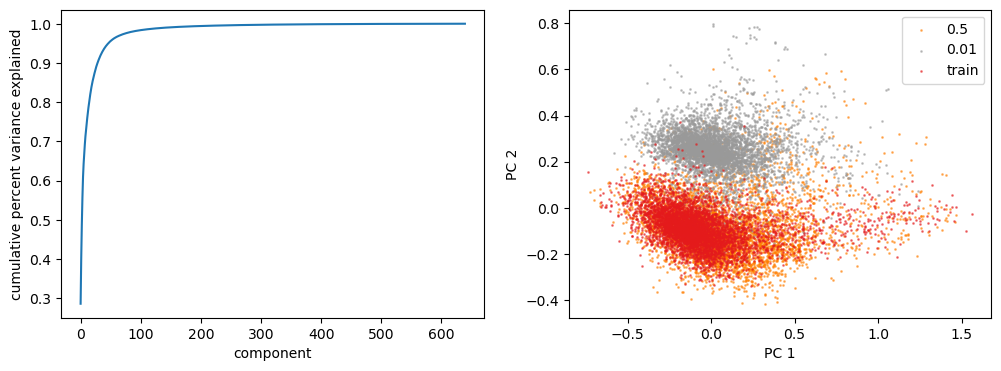

In [65]:
cmap = matplotlib.colormaps['Set1']
plt.figure(figsize=(12, 4))

pca = PCA()
pca.fit(allrep_xp)

plt.subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_));
for i in [0.7, 0.8, 0.9, 0.95]:
    idx = np.where(np.cumsum(pca.explained_variance_ratio_) >= i)[0]
    print('# PCs to explain {} variance: {}'.format(i, np.min(idx)))
plt.ylabel('cumulative percent variance explained');
plt.xlabel('component')

plt.subplot(122)

# PCs of design distributions
hp2pc = {}
for i, (hp_val, X_nxp) in enumerate(thresh2rep.items()):
    color = cmap((i + 1) / len(hp_vals))
    testpc_nxp = pca.transform(X_nxp)
    hp2pc[hp_val] = testpc_nxp
    plt.scatter(testpc_nxp[:, 0], testpc_nxp[:, 1], color=color, s=1, alpha=0.5, label=hp_val)
    
# PCs of train distribution
trainpc_nxp = pca.transform(trainrep_nxp)
plt.scatter(trainpc_nxp[:, 0], trainpc_nxp[:, 1], color=cmap(0), s=1, alpha=0.5, label='train')
hp2pc['train'] = trainpc_nxp

# PCs of calibration distribution
calpc_nxp = pca.transform(calrep_nxp)
hp2pc['cal'] = calpc_nxp

plt.legend()
plt.xlabel('PC 1');
plt.ylabel('PC 2');

In [86]:
n_pc = 43
hp2kde = {}

for hp_val in hp_vals:
    print(hp_val)
    print()
    cv = GridSearchCV(KernelDensity(), {'bandwidth': np.logspace(-2, 0, 5)}, cv=5, verbose=3)
    cv.fit(thresh2pc[hp_val][:, : n_pc])
    print(cv.best_params_)
    hp2kde[hp_val] = cv.best_estimator_
    
cv = GridSearchCV(KernelDensity(), {'bandwidth': np.logspace(-2, 0, 5)}, cv=5, verbose=3)
cv.fit(thresh2pc['train'][:, : n_pc])
print(cv.best_params_)
hp2kde['train'] = cv.best_estimator_


0.9

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............bandwidth=0.01;, score=-61216.307 total time=   0.3s
[CV 2/5] END ................bandwidth=0.01;, score=-3149.824 total time=   0.3s
[CV 3/5] END ..................bandwidth=0.01;, score=585.862 total time=   0.3s
[CV 4/5] END ...............bandwidth=0.01;, score=-31253.212 total time=   0.3s
[CV 5/5] END ...............bandwidth=0.01;, score=-66975.195 total time=   0.3s
[CV 1/5] END .bandwidth=0.03162277660168379;, score=75320.836 total time=   0.4s
[CV 2/5] END .bandwidth=0.03162277660168379;, score=81142.206 total time=   0.4s
[CV 3/5] END .bandwidth=0.03162277660168379;, score=81280.907 total time=   0.4s
[CV 4/5] END .bandwidth=0.03162277660168379;, score=80631.136 total time=   0.4s
[CV 5/5] END .bandwidth=0.03162277660168379;, score=73625.297 total time=   0.4s
[CV 1/5] END .bandwidth=0.09999999999999999;, score=50506.064 total time=   0.6s
[CV 2/5] END .bandwidth=0.09999999999999999;

[CV 4/5] END ................bandwidth=1.0;, score=-39641.837 total time=   0.6s
[CV 5/5] END ................bandwidth=1.0;, score=-39647.161 total time=   0.6s
{'bandwidth': 0.03162277660168379}
0.1

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ................bandwidth=0.01;, score=82975.834 total time=   0.3s
[CV 2/5] END ................bandwidth=0.01;, score=93257.903 total time=   0.3s
[CV 3/5] END ................bandwidth=0.01;, score=91813.200 total time=   0.3s
[CV 4/5] END ................bandwidth=0.01;, score=95376.361 total time=   0.3s


KeyboardInterrupt: 

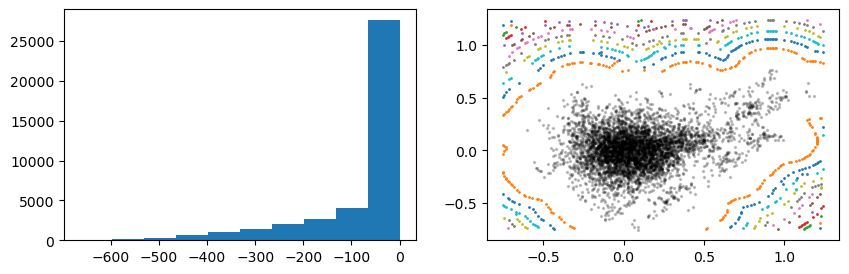

In [53]:
# visualize contours
hp_val = 0.9
bw = 0.021544346900318832


plt.figure(figsize=(10, 3))
plt.subplot(122)
plt.scatter(thresh2pc[hp_val][:, 0], thresh2pc[hp_val][:, 1], color='k', alpha=0.2, s=2);

kde = KernelDensity(bandwidth=bw)
kde.fit(thresh2pc[hp_val][:, : 2])
x, y = np.mgrid[-0.75:1.25:0.01, -0.75:1.25:0.01]
grid = np.hstack([x.ravel()[:, None], y.ravel()[:, None]])
gridll = kde.score_samples(grid)

plt.subplot(121)
plt.hist(gridll);

plt.subplot(122)
for val in np.arange(-600, 0, 50):
    idx = np.where(np.abs(gridll - val) < 1)
    plt.scatter(grid[idx, 0], grid[idx, 1], s=1)

# forecast with KDE

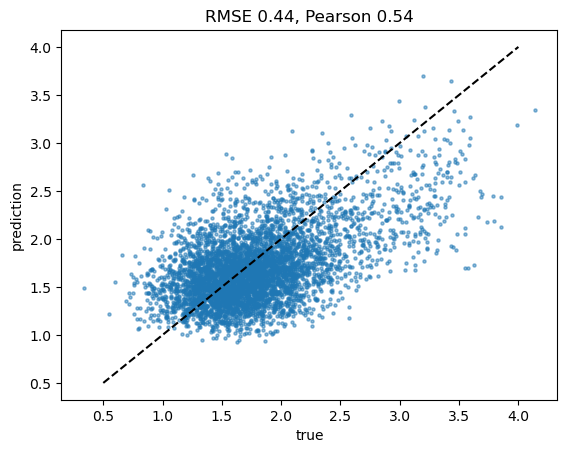

In [66]:
xy_lim = [0.5, 4]
plt.scatter(ycal_n, predcal_n, alpha=0.5, s=5)
rmse = np.sqrt(np.mean(np.square(predcal_n - ycal_n)))
r, p = sc.stats.pearsonr(predcal_n, ycal_n)
plt.xlabel('true'); plt.ylabel('prediction');
plt.plot(xy_lim, xy_lim, '--k');
plt.title('RMSE {:.2f}, Pearson {:.2f}'.format(rmse, r));

In [70]:
bw = 0.5
n_pc = 46

train_kde = KernelDensity(bandwidth=bw)
train_kde.fit(hp2pc['train'][:, : n_pc])
forecast_m = []
    
for hp_val in hp_vals:
    
    kde = KernelDensity(bandwidth=bw)
    kde.fit(hp2pc[hp_val][:, : n_pc])
    
    numll_n = kde.score_samples(calpc_nxp[:, : n_pc])
    denomll_n = train_kde.score_samples(calpc_nxp[:, : n_pc])
    ldr_n = numll_n - denomll_n
    
    # normalization
    c = np.max(ldr_n)
    normalization = c + np.log(np.sum(np.exp(ldr_n - c)))
    normalizeddr_n = np.exp(ldr_n - normalization) * ldr_n.size
    # normalizeddr_n = np.exp(ldr_n)  # not normalized lol
    
    hp_idx = hp_vals.index(hp_val)
    weightedrect_n = normalizeddr_n * (predcal_n - ycal_n)
    forecast = np.mean(pred_mxn[hp_idx]) - np.mean(weightedrect_n)

    truemean_m = np.mean(y_mxn, axis=1)
    imputed_m = np.mean(pred_mxn, axis=1)
    print('HP: {}. True: {:.2f}. Imputed: {:.2f}. PP: {:.2f}.'.format(
        hp_val, truemean_m[hp_idx], imputed_m[hp_idx], forecast 
    ))
    forecast_m.append(forecast)
forecast_m = np.array(forecast_m)

HP: 0.5. True: 2.47. Imputed: 2.18. PP: 2.32.
HP: 0.01. True: 3.11. Imputed: 3.23. PP: 3.37.


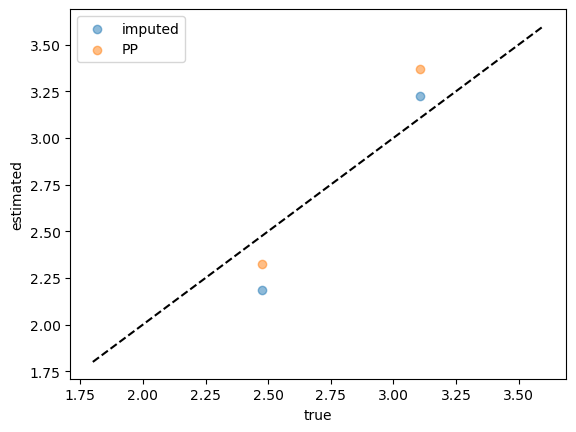

In [67]:
plt.scatter(truemean_m, imputed_m, alpha=0.5);
plt.scatter(truemean_m, forecast_m, alpha=0.5);
plt.plot([1.8, 3.6], [1.8, 3.6], '--k');
plt.legend(['imputed', 'PP']);
plt.xlabel('true');
plt.ylabel('estimated');

-0.14005129810310712


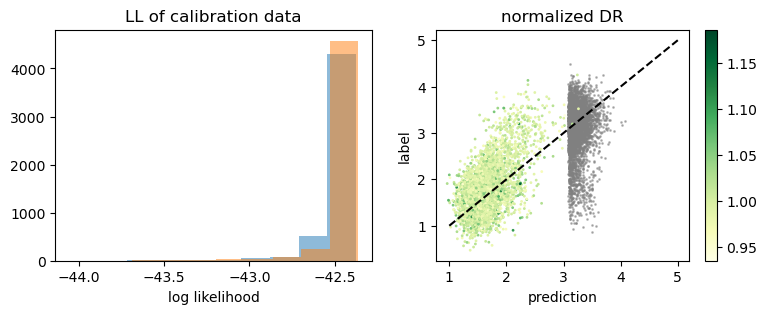

In [74]:
# inspecting KDEs
bw = 1
n_pc = 46
hp_val = 0.01
hp_idx = hp_vals.index(hp_val)

train_kde = KernelDensity(bandwidth=bw)
train_kde.fit(np.vstack([hp2pc['train'][:, : n_pc], hp2pc['cal'][:, : n_pc]]))
    
kde = KernelDensity(bandwidth=bw)
kde.fit(hp2pc[hp_val][:, : n_pc])

numll_n = kde.score_samples(hp2pc['cal'][:, : n_pc])
denomll_n = train_kde.score_samples(hp2pc['cal'][:, : n_pc])
ldr_n = numll_n - denomll_n

# normalization
c = np.max(ldr_n)
normalization = c + np.log(np.sum(np.exp(ldr_n - c)))
normalizeddr_n = np.exp(ldr_n - normalization) * ldr_n.size
print(np.mean(normalizeddr_n * (predcal_n - ycal_n)))

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(numll_n, alpha=0.5, label='design dist');
plt.hist(denomll_n, alpha=0.5, label='train dist');
plt.xlabel('log likelihood')
plt.title('LL of calibration data')

plt.subplot(122)
plt.plot([1, 5], [1, 5], '--k')
plt.scatter(pred_mxn[hp_idx, :], y_mxn[hp_idx, :], s=1, alpha=0.5, color='gray');
plt.scatter(predcal_n, ycal_n, s=1, alpha=1, c=normalizeddr_n, cmap='YlGn');
plt.colorbar()
hp_idx = hp_vals.index(hp_val)
plt.title('normalized DR');
plt.xlabel('prediction');
plt.ylabel('label');

# layer of CNN

Generating 10000 labeled training and calibration data...
Done. (31 s)


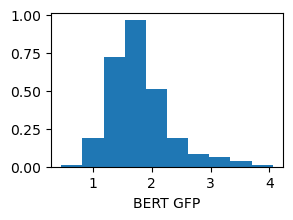

In [93]:
# generate training data
n = 10000
n_cal = 5000
avg_n_mut = 5
noise_sd = 0.3

gfp_landscape = flexs.landscapes.BertGFPBrightness()
seed = gfp_landscape.starts['ed_18_wt']

p_mut = avg_n_mut / 238
trainseqs_n = [dd.get_mutant(seed, p_mut, s_utils.AAS) for _ in range(n)]
print('Generating {} labeled training and calibration data...'.format(n))
t0 = time()
ytrain_n = gfp_landscape.get_fitness(trainseqs_n)
noise_n = sc.stats.norm.rvs(loc=0, scale=noise_sd, size=len(trainseqs_n))
ytrain_n = ytrain_n + noise_n
print('Done. ({} s)'.format(int(time() - t0)))

trainseqs_n, calseqs_n = trainseqs_n[: n - n_cal], trainseqs_n[n - n_cal :]
ytrain_n, ycal_n = ytrain_n[: n - n_cal], ytrain_n[n - n_cal :]

plt.figure(figsize=(3, 2));
plt.hist(ycal_n, density=True);
plt.xlabel('BERT GFP');

In [24]:
model_class = flexs.baselines.models.CNN
model_kwargs = {
    'num_filters': 64,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 128,
}

print('Training...')
t0 = time()
model = flexs.Ensemble([
    model_class(len(trainseqs_n[0]), alphabet=s_utils.AAS, **model_kwargs)
    for i in range(3)
])
model.train(trainseqs_n, ytrain_n)
print('Done. ({} s)'.format(int(time() - t0)))

Training...
Done. (15 s)


40/40 [==============================] - 0s 2ms/step


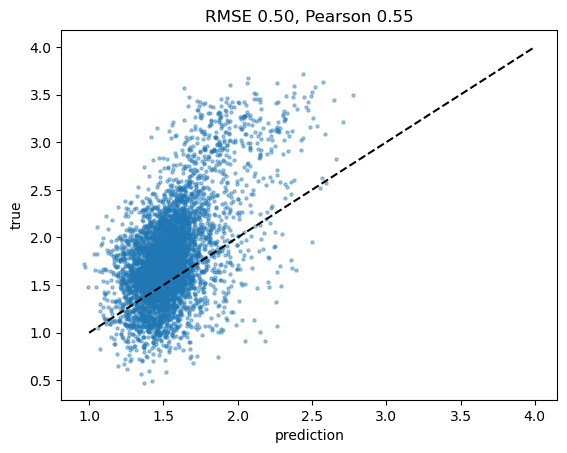

In [26]:
xy_lim = [1, 4]
predcal_n = model.get_fitness(calseqs_n)
rmse = np.sqrt(np.mean(np.square(predcal_n - ycal_n)))
r, p = sc.stats.pearsonr(predcal_n, ycal_n)
plt.scatter(predcal_n, ycal_n, alpha=0.4, s=5)
plt.ylabel('true'); plt.xlabel('prediction');
plt.plot(xy_lim, xy_lim, '--k');
plt.title('RMSE {:.2f}, Pearson {:.2f}'.format(rmse, r));

In [12]:
model.models[0].model.layers

In [27]:
functors = []
for i in range(3):
    inp = model.models[i].model.input                                       # input placeholder
    outputs = [layer.output for layer in model.models[i].model.layers]      # all layer outputs
    functor = K.function([inp], outputs)   # evaluation function
    functors.append(functor)

def get_cnn_layer(seq_n, layer_idx: int = 6, n_model: int = 3):
    X_nxp = np.stack([s_utils.string_to_one_hot(seq, s_utils.AAS) for seq in seq_n])
    reps = []
    for i in range(n_model):
        reps.append(functors[i]([X_nxp])[layer_idx])
    rep_nxp = np.concatenate(reps, axis=1)
    return rep_nxp

In [28]:
layer_idx = 6
n_model = 3

thresh2rep = {}
t0 = time()
for i, testseqs_n in enumerate(testseqs_list):
    rep_nxp = get_cnn_layer(testseqs_n, layer_idx=layer_idx, n_model=n_model)
    thresh2rep[hp_vals[i]] = rep_nxp
    print('done with {} / {} ({} s)'.format(i, len(testseqs_list), int(time() - t0)))
allrep_xp = np.vstack([v for v in thresh2rep.values()])

# training sequences
trainrep_nxp = get_cnn_layer(trainseqs_n, layer_idx=layer_idx, n_model=n_model)

# calibration sequences
calrep_nxp = get_cnn_layer(calseqs_n, layer_idx=layer_idx, n_model=n_model)
allrep_xp = np.vstack([trainrep_nxp, calrep_nxp, allrep_xp])

done with 0 / 7 (5 s)
done with 1 / 7 (10 s)
done with 2 / 7 (16 s)
done with 3 / 7 (21 s)
done with 4 / 7 (26 s)
done with 5 / 7 (32 s)
done with 6 / 7 (37 s)


In [52]:
# pre-saved embeddings

thresh2rep = {}
for i, emb_nxd in enumerate(testembs_list):
    thresh2rep[hp_vals[i]] = emb_nxd
    
# training sequences
trainrep_nxp = embtr_nxd.copy()

# calibration sequences
calrep_nxp = embcal_nxd.copy()

allrep_xp = np.vstack([trainrep_nxp, calrep_nxp] + testembs_list)

# PCs to explain 0.7 variance: 0
# PCs to explain 0.8 variance: 1
# PCs to explain 0.9 variance: 1
# PCs to explain 0.95 variance: 2


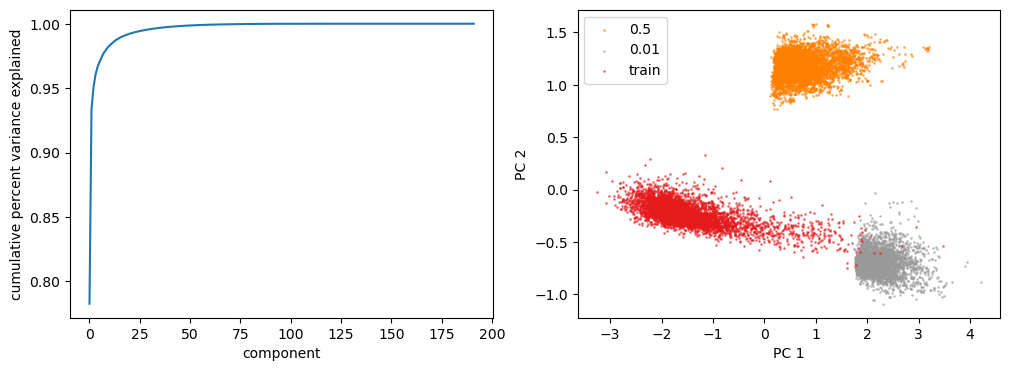

In [53]:
cmap = matplotlib.colormaps['Set1']
plt.figure(figsize=(12, 4))

pca = PCA()
pca.fit(allrep_xp)

plt.subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_));
for i in [0.7, 0.8, 0.9, 0.95]:
    idx = np.where(np.cumsum(pca.explained_variance_ratio_) >= i)[0]
    print('# PCs to explain {} variance: {}'.format(i, np.min(idx)))
plt.ylabel('cumulative percent variance explained');
plt.xlabel('component')

plt.subplot(122)

# PCs of design distributions
hp2pc = {}
for i, (hp_val, X_nxp) in enumerate(thresh2rep.items()):
    color = cmap((i + 1) / len(hp_vals))
    testpc_nxp = pca.transform(X_nxp)
    hp2pc[hp_val] = testpc_nxp
    plt.scatter(testpc_nxp[:, 0], testpc_nxp[:, 1], color=color, s=1, alpha=0.5, label=hp_val)
    
# PCs of train distribution
trainpc_nxp = pca.transform(trainrep_nxp)
plt.scatter(trainpc_nxp[:, 0], trainpc_nxp[:, 1], color=cmap(0), s=1, alpha=0.5, label='train')
hp2pc['train'] = trainpc_nxp

# PCs of calibration distribution
calpc_nxp = pca.transform(calrep_nxp)
hp2pc['cal'] = calpc_nxp

plt.legend()
plt.xlabel('PC 1');
plt.ylabel('PC 2');

In [31]:
n_pc = 2
hp2kde = {}

for hp_val in hp_vals:
    print(hp_val)
    print()
    cv = GridSearchCV(KernelDensity(), {'bandwidth': np.logspace(-3, -1, 8)}, cv=5, verbose=3)
    cv.fit(hp2pc[hp_val][:, : n_pc])
    print(cv.best_params_)
    hp2kde[hp_val] = cv.best_estimator_
    
cv = GridSearchCV(KernelDensity(), {'bandwidth': np.logspace(-3, -1, 8)}, cv=5, verbose=3)
cv.fit(hp2pc['train'][:, : n_pc])
print(cv.best_params_)
hp2kde['train'] = cv.best_estimator_


0.9

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ............bandwidth=0.001;, score=-1000502.625 total time=   0.0s
[CV 2/5] END .............bandwidth=0.001;, score=-373571.677 total time=   0.0s
[CV 3/5] END .............bandwidth=0.001;, score=-246773.193 total time=   0.0s
[CV 4/5] END .............bandwidth=0.001;, score=-819686.017 total time=   0.0s
[CV 5/5] END ...........bandwidth=0.001;, score=-44947791.561 total time=   0.0s
[CV 1/5] END bandwidth=0.0019306977288832496;, score=-260701.716 total time=   0.0s
[CV 2/5] END bandwidth=0.0019306977288832496;, score=-96132.426 total time=   0.0s
[CV 3/5] END bandwidth=0.0019306977288832496;, score=-60656.763 total time=   0.0s
[CV 4/5] END bandwidth=0.0019306977288832496;, score=-214458.732 total time=   0.0s
[CV 5/5] END bandwidth=0.0019306977288832496;, score=-12034744.510 total time=   0.0s
[CV 1/5] END bandwidth=0.003727593720314938;, score=-69007.335 total time=   0.0s
[CV 2/5] END bandwidth=0.003

[CV 5/5] END bandwidth=0.0071968567300115215;, score=-106392.213 total time=   0.1s
[CV 1/5] END bandwidth=0.013894954943731374;, score=-2704.841 total time=   0.1s
[CV 2/5] END bandwidth=0.013894954943731374;, score=-1059.870 total time=   0.1s
[CV 3/5] END .bandwidth=0.013894954943731374;, score=-904.490 total time=   0.1s
[CV 4/5] END bandwidth=0.013894954943731374;, score=-1212.184 total time=   0.1s
[CV 5/5] END bandwidth=0.013894954943731374;, score=-28899.652 total time=   0.1s
[CV 1/5] END bandwidth=0.026826957952797246;, score=-1366.507 total time=   0.1s
[CV 2/5] END .bandwidth=0.026826957952797246;, score=-773.668 total time=   0.1s
[CV 3/5] END .bandwidth=0.026826957952797246;, score=-641.795 total time=   0.1s
[CV 4/5] END .bandwidth=0.026826957952797246;, score=-767.325 total time=   0.1s
[CV 5/5] END bandwidth=0.026826957952797246;, score=-8736.660 total time=   0.1s
[CV 1/5] END ..bandwidth=0.0517947467923121;, score=-1066.694 total time=   0.2s
[CV 2/5] END ...bandwidt

[CV 4/5] END ..bandwidth=0.09999999999999999;, score=-674.589 total time=   0.2s
[CV 5/5] END .bandwidth=0.09999999999999999;, score=-1620.473 total time=   0.2s
{'bandwidth': 0.0517947467923121}
0.05

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..............bandwidth=0.001;, score=-80709.670 total time=   0.0s
[CV 2/5] END ..............bandwidth=0.001;, score=-94678.161 total time=   0.1s
[CV 3/5] END .............bandwidth=0.001;, score=-111010.801 total time=   0.1s
[CV 4/5] END ..............bandwidth=0.001;, score=-65212.832 total time=   0.1s
[CV 5/5] END ............bandwidth=0.001;, score=-1274359.233 total time=   0.0s
[CV 1/5] END bandwidth=0.0019306977288832496;, score=-17235.786 total time=   0.1s
[CV 2/5] END bandwidth=0.0019306977288832496;, score=-23678.649 total time=   0.1s
[CV 3/5] END bandwidth=0.0019306977288832496;, score=-27477.659 total time=   0.1s
[CV 4/5] END bandwidth=0.0019306977288832496;, score=-13851.510 total time=   0.1s
[

[CV 1/5] END bandwidth=0.0071968567300115215;, score=-4583.342 total time=   0.1s
[CV 2/5] END bandwidth=0.0071968567300115215;, score=-2784.920 total time=   0.1s
[CV 3/5] END bandwidth=0.0071968567300115215;, score=-4592.735 total time=   0.1s
[CV 4/5] END bandwidth=0.0071968567300115215;, score=-21707.630 total time=   0.1s
[CV 5/5] END bandwidth=0.0071968567300115215;, score=-4498.320 total time=   0.1s
[CV 1/5] END .bandwidth=0.013894954943731374;, score=-990.048 total time=   0.1s
[CV 2/5] END .bandwidth=0.013894954943731374;, score=-576.744 total time=   0.1s
[CV 3/5] END .bandwidth=0.013894954943731374;, score=-922.276 total time=   0.1s
[CV 4/5] END bandwidth=0.013894954943731374;, score=-5656.513 total time=   0.1s
[CV 5/5] END .bandwidth=0.013894954943731374;, score=-985.442 total time=   0.1s
[CV 1/5] END .bandwidth=0.026826957952797246;, score=-200.352 total time=   0.2s
[CV 2/5] END ..bandwidth=0.026826957952797246;, score=-74.632 total time=   0.1s
[CV 3/5] END .bandwidt

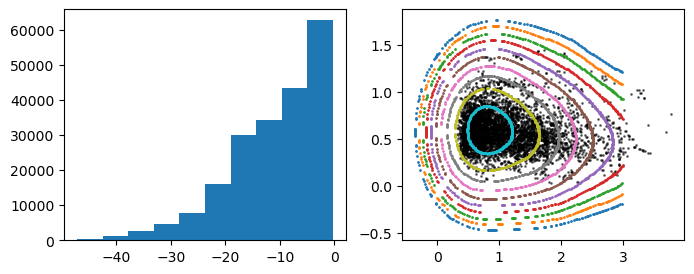

In [24]:
# inspecting KDEs
bw = 0.3
n_pc = 2
hp_val = 0.5

train_kde = KernelDensity(bandwidth=bw)
train_kde.fit(hp2pc[hp_val][:, : n_pc])

x, y = np.mgrid[-1.5:3:0.01, -1.5:3:0.01]
grid = np.hstack([x.ravel()[:, None], y.ravel()[:, None]])
gridll = train_kde.score_samples(grid)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.hist(gridll);

plt.subplot(122)
plt.scatter(hp2pc[hp_val][:, 0], hp2pc[hp_val][:, 1], s=1, color='k', alpha=0.5)
for val in np.arange(-5, 2.1, 0.5):
    idx = np.where(np.abs(gridll - val) < 0.01)
    plt.scatter(grid[idx, 0], grid[idx, 1], s=1)

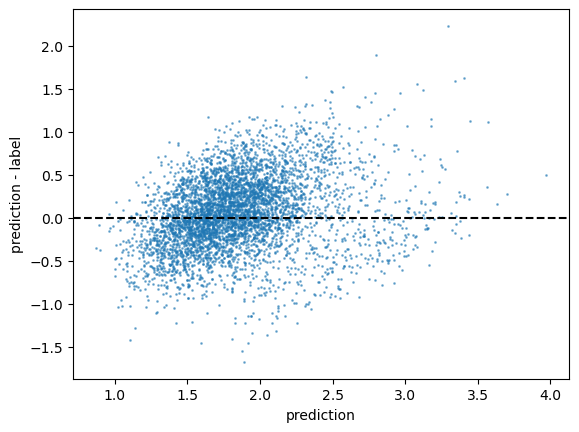

In [12]:
plt.scatter(predcal_n, predcal_n - ycal_n, s=1, alpha=0.5);
plt.axhline(0, linestyle='--', color='k');
plt.ylabel('prediction - label'); plt.xlabel('prediction');

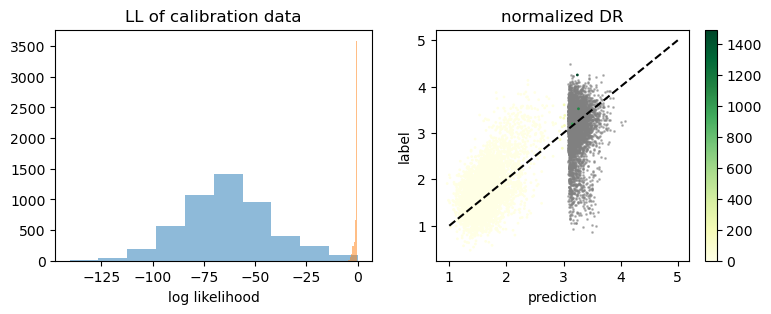

In [55]:
# inspecting KDEs
bw = 0.3
n_pc = 2
hp_val = 0.01
hp_idx = hp_vals.index(hp_val)

train_kde = KernelDensity(bandwidth=bw)
train_kde.fit(np.vstack([hp2pc['train'][:, : n_pc], hp2pc['cal'][:, : n_pc]]))
    
kde = KernelDensity(bandwidth=bw)
kde.fit(hp2pc[hp_val][:, : n_pc])

numll_n = kde.score_samples(hp2pc['cal'][:, : n_pc])
denomll_n = train_kde.score_samples(hp2pc['cal'][:, : n_pc])
ldr_n = numll_n - denomll_n

# normalization
c = np.max(ldr_n)
normalization = c + np.log(np.sum(np.exp(ldr_n - c)))
normalizeddr_n = np.exp(ldr_n - normalization) * ldr_n.size

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(numll_n, alpha=0.5, label='design dist');
plt.hist(denomll_n, alpha=0.5, label='train dist');
plt.xlabel('log likelihood')
plt.title('LL of calibration data')

plt.subplot(122)
plt.plot([1, 5], [1, 5], '--k')
plt.scatter(pred_mxn[hp_idx, :], y_mxn[hp_idx, :], s=1, alpha=0.5, color='gray');
plt.scatter(predcal_n, ycal_n, s=1, alpha=1, c=normalizeddr_n, cmap='YlGn');
plt.colorbar()
hp_idx = hp_vals.index(hp_val)
plt.title('normalized DR');
plt.xlabel('prediction');
plt.ylabel('label');

In [75]:
bw = 1
n_pc = 46
threshold = 1.9

train_kde = KernelDensity(bandwidth=bw)
train_kde.fit(hp2pc['train'][:, : n_pc])
forecast_m = []
normalizeddr_m = []
    
for hp_val in hp_vals:

    hp_idx = hp_vals.index(hp_val)
    kde = KernelDensity(bandwidth=bw)
    kde.fit(np.vstack([hp2pc[hp_val][:, : n_pc], hp2pc['cal'][:, : n_pc]]))  # 1.25 WRONG
    
    numll_n = kde.score_samples(hp2pc['cal'][:, : n_pc])
    denomll_n = train_kde.score_samples(hp2pc['cal'][:, : n_pc])
    ldr_n = numll_n - denomll_n
    
    # normalization
    c = np.max(ldr_n)
    normalization = c + np.log(np.sum(np.exp(ldr_n - c)))
    normalizeddr_n = np.exp(ldr_n - normalization) * ldr_n.size
    # normalizeddr_n = np.exp(ldr_n)  # not normalized lol
    normalizeddr_m.append(normalizeddr_n)
    
    # weightedrect_n = normalizeddr_n * ((predcal_n > threshold).astype(float) - (ycal_n > threshold).astype(float))
    # forecast = np.mean(pred_mxn[hp_idx] > threshold) - np.mean(weightedrect_n)
    weightedrect_n = normalizeddr_n * (predcal_n - ycal_n)
    forecast = np.mean(pred_mxn[hp_idx]) - np.mean(weightedrect_n)
    
    # truemean_m = np.mean(y_mxn > threshold, axis=1)
    # imputed_m = np.mean(pred_mxn > threshold, axis=1)
    truemean_m = np.mean(y_mxn, axis=1)
    imputed_m = np.mean(pred_mxn, axis=1)
    print('HP: {}. True: {:.2f}. Imputed: {:.2f}. PP: {:.2f}.'.format(
        hp_val, truemean_m[hp_idx], imputed_m[hp_idx], forecast 
    ))
    forecast_m.append(forecast)
forecast_m = np.array(forecast_m)

HP: 0.5. True: 2.47. Imputed: 2.18. PP: 2.32.
HP: 0.01. True: 3.11. Imputed: 3.23. PP: 3.37.


In [45]:
import matplotlib as mpl

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [76]:
b = normalizeddr_m[1] / normalizeddr_m[0]
a = np.log(b)
np.min(b), np.max(b), np.median(b), np.min(a), np.max(a), np.median(a)

(0.947264580935726,
 1.0707705818705728,
 1.0008527651225334,
 -0.0541768362900718,
 0.06837855924835506,
 0.0008524017202412456)

In [46]:
norm = MidpointNormalize(vmin=-0.1, vmax=6, midpoint=0)
cmap = 'RdBu_r' 

plt.scatter(predcal_n, predcal_n - ycal_n, s=5, alpha=0.8, c=np.log(normalizeddr_m[1] / normalizeddr_m[0]), cmap=cmap, norm=norm);
plt.colorbar();
plt.axhline(0, linestyle='--', color='gray');

NameError: name 'normalizeddr_m' is not defined

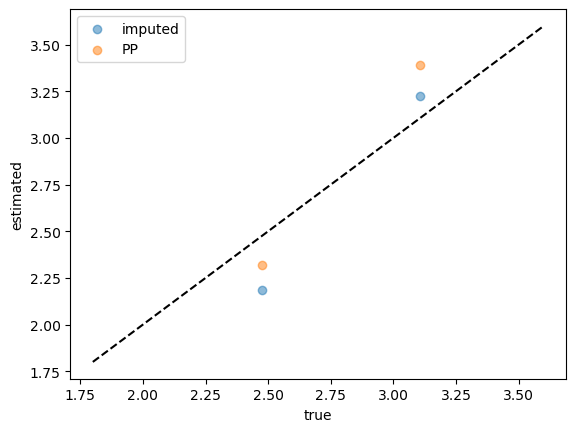

In [60]:
plt.scatter(truemean_m, imputed_m, alpha=0.5);
plt.scatter(truemean_m, forecast_m, alpha=0.5);
plt.plot([1.8, 3.6], [1.8, 3.6], '--k');
# plt.plot([0, 1], [0, 1], '--k');
plt.legend(['imputed', 'PP']);
plt.xlabel('true');
plt.ylabel('estimated');

# prediction-based KDE

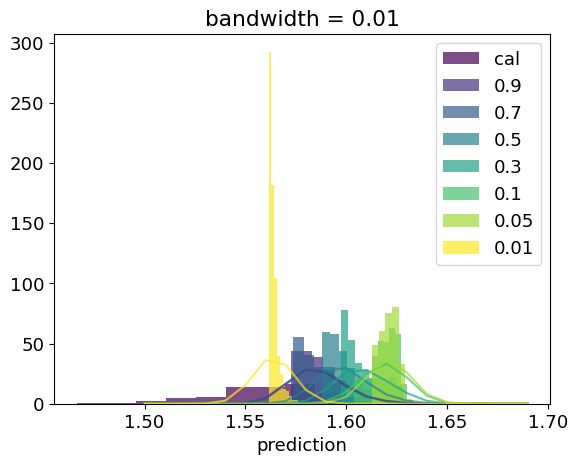

In [56]:
bw = 0.01
cmap = matplotlib.colormaps['viridis']

x_x1 = np.arange(1.5, 1.7, 0.01)[:, None]

plt.hist(predcal_n, color=cmap(0), alpha=0.7, label='cal', density=True)

kde = KernelDensity(bandwidth=bw)
for i, pred_n in enumerate(pred_mxn):
    color = cmap((i + 1) / len(hp_vals))
    plt.hist(pred_n, color=color, alpha=0.7, label=hp_vals[i], density=True)
    kde.fit(pred_n[:, None])
    ll = kde.score_samples(x_x1)
    plt.plot(x_x1, np.exp(ll), color=color, alpha=0.7)

plt.legend();
plt.xlabel('prediction');
plt.title('bandwidth = {}'.format(bw));

In [57]:
bw = 0.02
threshold = 2

train_kde = KernelDensity(bandwidth=bw)
train_kde.fit(predcal_n[:, None])
forecast_m = []
dr_mxn = []
    
for i, (hp_val, ytest_n, predtest_n) in enumerate(zip(hp_vals, y_mxn, pred_mxn)):

    hp_idx = hp_vals.index(hp_val)
    kde = KernelDensity(bandwidth=bw)
    kde.fit(predtest_n[:, None])
    
    numll_n = kde.score_samples(predcal_n[:, None])
    denomll_n = train_kde.score_samples(predcal_n[:, None])
    ldr_n = numll_n - denomll_n
    
    # normalization
    c = np.max(ldr_n)
    normalization = c + np.log(np.sum(np.exp(ldr_n - c)))
    normalizeddr_n = np.exp(ldr_n - normalization) * ldr_n.size
    # normalizeddr_n = np.exp(ldr_n)  # not normalized lol
    dr_mxn.append(normalizeddr_n)
    
#     weightedrect_n = normalizeddr_n * ((predcal_n > threshold).astype(float) - (ycal_n > threshold).astype(float))
#     forecast = np.mean(pred_mxn[hp_idx] > threshold) - np.mean(weightedrect_n)
    weightedrect_n = normalizeddr_n * (predcal_n - ycal_n)
    forecast = np.mean(pred_mxn[hp_idx]) - np.mean(weightedrect_n)
    
#     print('HP: {}. True: {:.2f}. Imputed: {:.2f}. PP: {:.2f}.'.format(
#         hp_val, np.mean(ytest_n), np.mean(predtest_n), forecast 
#     ))
    print('HP: {}. True: {:.2f}. Imputed: {:.2f}. PP: {:.2f}.'.format(
        hp_val, np.mean(ytest_n > threshold), np.mean(predtest_n > threshold), forecast 
    ))
    forecast_m.append(forecast)
dr_mxn = np.array(dr_mxn)
forecast_m = np.array(forecast_m)


HP: 0.9. True: 0.22. Imputed: 0.00. PP: 0.16.
HP: 0.7. True: 0.19. Imputed: 0.00. PP: 0.17.
HP: 0.5. True: 0.51. Imputed: 0.00. PP: 0.19.
HP: 0.3. True: 0.86. Imputed: 0.00. PP: 0.21.
HP: 0.1. True: 0.91. Imputed: 0.00. PP: 0.22.
HP: 0.05. True: 0.92. Imputed: 0.00. PP: 0.23.
HP: 0.01. True: 0.93. Imputed: 0.00. PP: 0.12.


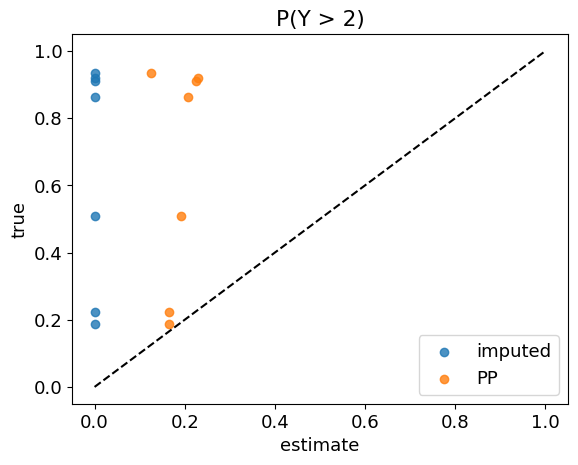

In [60]:
xy_lim = [0, 1]# [1.8, 3.6]
# truemean_m = np.mean(y_mxn, axis=1)
# imputed_m = np.mean(pred_mxn, axis=1)
truemean_m = np.mean(y_mxn > threshold, axis=1)
imputed_m = np.mean(pred_mxn > threshold, axis=1)
plt.scatter(imputed_m, truemean_m, alpha=0.8, label='imputed');
plt.scatter(forecast_m, truemean_m, alpha=0.8, label='PP');
plt.plot(xy_lim, xy_lim, '--k');
plt.legend();
plt.xlabel('estimate');
plt.ylabel('true');
plt.title('P(Y > {})'.format(threshold));

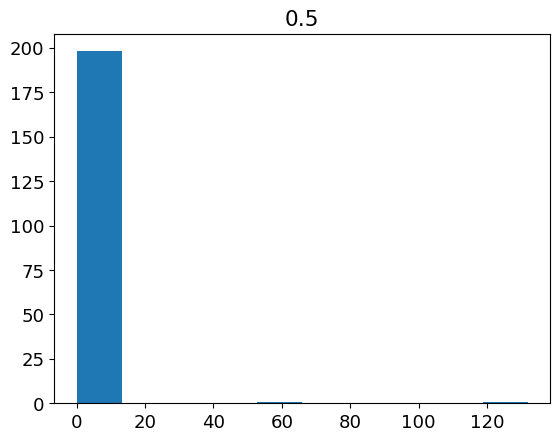

In [44]:
i = 2
plt.hist(dr_mxn[i]);
plt.title(hp_vals[i]);

In [55]:
tau = 2.7
alpha = 0.1
pval_format_str = ''.join(len(hp_vals) * ['{:.3f} '])

print('Imputed:')

imppvals = [
    _zstat_generic(imp_est, 0, np.std(pred_n) / np.sqrt(pred_n.size), alternative='larger', diff=tau)[1]
    for imp_est, pred_n in zip(imputed_m, pred_mxn)]
print(pval_format_str.format(*imppvals))

impidx = np.where(np.array(imppvals) < alpha / len(hp_vals))[0]
if impidx.size:
    if np.sum(truemean_m[impidx] > tau) < impidx.size:
        impfwer = 1
    print('  {:.3f} {:.3f}. {} {}'.format(np.min(truemean_m[impidx]), np.max(truemean_m[impidx]), impidx.size, impfwer))
else:
    print('  No hyperparameters selected')
    
print('PPI++:')

pppvals = [
    cal.ppi_mean_pval(
        ycal_n, predcal_n, pred0_n,
        lhat=1, null=tau, alternative='larger', w=dr_n
    ) for pred0_n, dr_n in zip(pred_mxn, dr_mxn)
]
print(pval_format_str.format(*pppvals))

ppidx = np.where(np.array(pppvals) < alpha / len(hp_vals))[0]
if ppidx.size:
    if np.sum(truemean_m[ppidx] > tau) < ppidx.size:
        ppfwer = 1
    print('  {:.3f} {:.3f}. {} {}'.format(
        np.min(truemean_m[ppidx]), np.max(truemean_m[ppidx]), ppidx.size, ppfwer))
else:
    print('  No hyperparameters selected')

Imputed:
1.000 1.000 0.000 0.000 0.000 0.000 0.000 
  2.482 3.396. 5 1
PPI++:
1.000 1.000 1.000 0.000 0.000 0.001 0.034 
  3.051 3.348. 3 1
